In [1]:
from my_import import *
df_train = pd.read_csv('df_train.csv')
df_val = pd.read_csv('df_val.csv')
df_test = pd.read_csv('df_test.csv')
df_full = pd.read_csv('final_cleaned_dataset_df.csv')

#Make sure the genre collumns is in lists not strings
#NEED TO DO THIS EVERYTIME EXPORT DATASET
df_train['genres'] = df_train['genres'].apply(lambda x: list(ast.literal_eval(x)))
df_val['genres'] = df_val['genres'].apply(lambda x: list(ast.literal_eval(x)))
df_test['genres'] = df_test['genres'].apply(lambda x: list(ast.literal_eval(x)))

df_train=df_train.drop(columns=['title','index'])
df_val=df_val.drop(columns=['title','index'])
df_test=df_test.drop(columns=['title','index'])


display(df_train)

c:\Users\User\anaconda3\envs\nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,synopsis,genres
0,"Sometime in the future, the world was complete...","[Action, Adventure]"
1,"Set in 2014, the anime follows the adventures ...",[Comedy]
2,Follows a pig whose family's mission is to col...,"[Comedy, Kids]"
3,"In honor of the 2018 World Cup, this season of...","[Kids, Sci-Fi, Sports, Super Power]"
4,"Fairies living in a fluffy forest, where both ...","[Fantasy, Kids]"
...,...,...
9189,The Konohagakure Grand Sports Festival has beg...,"[Action, Comedy, Fantasy, Other, Shounen, Sports]"
9190,Special bundled with the Blu-ray/DVD volume of .,[Ecchi]
9191,"According to the official Hobby Japan website,...","[Comedy, Ecchi, Fantasy, Parody]"
9192,A series of comedic shorts featuring chibi ver...,"[Adventure, Comedy, Fantasy, Parody]"


Using device: cuda


C:\Users\User\AppData\Local\Temp\ipykernel_25476\4186845695.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  train_labels = torch.tensor(list(df_train["labels"].values))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Training: 100%|██████████| 1150/1150 [14:22<00:00,  1.33it/s]


Train Loss: 0.3325


Validating: 100%|██████████| 143/143 [00:41<00:00,  3.44it/s]


Val Loss: 0.2942 | F1 (samples): 0.0334

Epoch 2/4


Training: 100%|██████████| 1150/1150 [15:19<00:00,  1.25it/s]


Train Loss: 0.2820


Validating: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s]


Val Loss: 0.2640 | F1 (samples): 0.2391

Epoch 3/4


Training: 100%|██████████| 1150/1150 [15:22<00:00,  1.25it/s]


Train Loss: 0.2610


Validating: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s]


Val Loss: 0.2532 | F1 (samples): 0.2974

Epoch 4/4


Training: 100%|██████████| 1150/1150 [15:23<00:00,  1.25it/s]


Train Loss: 0.2480


Validating: 100%|██████████| 143/143 [00:41<00:00,  3.43it/s]


Val Loss: 0.2437 | F1 (samples): 0.3916


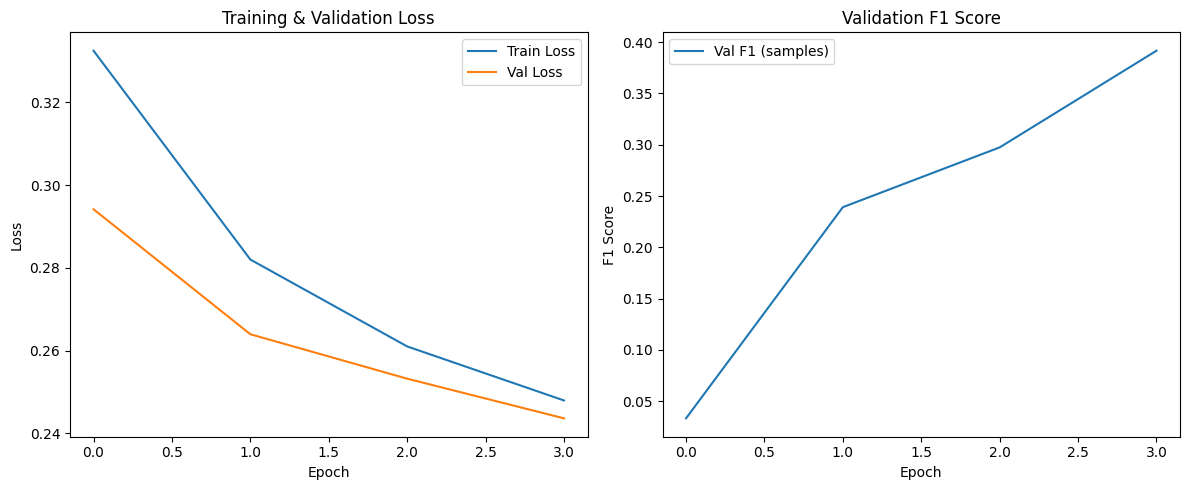

Testing: 100%|██████████| 141/141 [00:41<00:00,  3.42it/s]


Test Loss: 0.2450
Test F1 (samples): 0.3931 | Jaccard: 0.3014 | Hit Rate: 0.6673


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from sklearn.metrics import f1_score, jaccard_score
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== STEP 1: Device & Data ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

all_genres = sorted(set(genre for sublist in df_train["genres"] for genre in sublist))
label2id = {genre: idx for idx, genre in enumerate(all_genres)}
id2label = {idx: genre for genre, idx in label2id.items()}
num_labels = len(label2id)

def encode_labels(genres):
    vec = np.zeros(num_labels, dtype=np.float32)
    for genre in genres:
        vec[label2id[genre]] = 1.0
    return vec

df_train["labels"] = df_train["genres"].apply(encode_labels)
df_val["labels"] = df_val["genres"].apply(encode_labels)
df_test["labels"] = df_test["genres"].apply(encode_labels)

model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=False)

train_encodings = tokenizer(df_train["synopsis"].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=256)
val_encodings = tokenizer(df_val["synopsis"].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=256)
test_encodings = tokenizer(df_test["synopsis"].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=256)

train_labels = torch.tensor(list(df_train["labels"].values))
val_labels = torch.tensor(list(df_val["labels"].values))
test_labels = torch.tensor(list(df_test["labels"].values))

train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
val_dataset = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], val_labels)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

config = AutoConfig.from_pretrained(model_ckpt, num_labels=num_labels, problem_type="multi_label_classification", id2label=id2label, label2id=label2id,hidden_dropout_prob=0.3 )
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5,weight_decay=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()

num_epochs = 4
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    for batch in tqdm(train_loader, desc="Training"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # ===== Validation =====
    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()

            preds = torch.sigmoid(logits) > 0.5
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    y_true = np.vstack(all_labels)
    y_pred = np.vstack(all_preds)
    val_acc = f1_score(y_true, y_pred, average="samples")
    val_accuracies.append(val_acc)

    print(f"Val Loss: {avg_val_loss:.4f} | F1 (samples): {val_acc:.4f}")

    # Save model checkpoint
    torch.save(model.state_dict(), f"checkpoint_epoch{epoch+1}.pt")

# ====== Plotting ======
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val F1 (samples)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

# ====== Final Test Evaluation ======
model.eval()
all_preds, all_labels = [], []
total_test_loss = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_test_loss += loss.item()

        preds = torch.sigmoid(logits) > 0.5
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_true = np.vstack(all_labels)
y_pred = np.vstack(all_preds)
test_f1 = f1_score(y_true, y_pred, average="samples")
test_jaccard = jaccard_score(y_true, y_pred, average="samples")
test_hit = (np.logical_and(y_true, y_pred).sum(axis=1) > 0).mean()
avg_test_loss = total_test_loss / len(test_loader)

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test F1 (samples): {test_f1:.4f} | Jaccard: {test_jaccard:.4f} | Hit Rate: {test_hit:.4f}")


In [4]:
def predict_genres(synopsis, threshold=0.5):
    model.eval()
    inputs = tokenizer(synopsis, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]

    predicted_indices = [i for i, p in enumerate(probs) if p > threshold]
    return [id2label[i] for i in predicted_indices]

# Example use
synopsis = "Student council president Miyuki Shirogane and vice-president Kaguya Shinomiya appear to be the perfect couple; but both are too proud to confess their love and scheme to make the other confess their love first."
genres = predict_genres(synopsis)
print("Genres:", genres)


Genres: ['Comedy', 'Romance', 'School']


In [5]:
model.save_pretrained("anime-genre-model-Roberta")
tokenizer.save_pretrained("anime-genre-model-Roberta")

('anime-genre-model-Roberta\\tokenizer_config.json',
 'anime-genre-model-Roberta\\special_tokens_map.json',
 'anime-genre-model-Roberta\\vocab.json',
 'anime-genre-model-Roberta\\merges.txt',
 'anime-genre-model-Roberta\\added_tokens.json')

In [11]:
tokenizer = AutoTokenizer.from_pretrained("anime-genre-model")
model = AutoModelForSequenceClassification.from_pretrained("anime-genre-model").to(device)

synopsis = "The year is 2052—an era of unprecedented peace and prosperity prevails across the globe. The reason for this: mankind has been freed from sickness and pain. Nobel Prize winning neuroscientist Dr. Skinner has developed a miracle cure-all drug with no apparent drawbacks called Hapuna. Hapuna soon becomes ubiquitous... and essential. However, soon after Hapuna is officially introduced, Dr. Skinner vanishes."
genres = predict_genres(synopsis)
print("Genres:", genres)


Genres: ['Sci-Fi']
